In [1]:
%load_ext autoreload
%autoreload 2

from scipy.stats import binom, beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from contamination_estimation import VariantPosition, estimate_contamination
# https://github.com/liguowang/dcon/blob/master/lib/DconModule/utils.py

In [7]:
def plot_result(vp, dist, sorted_likelihoods):
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(131)
    ax.set_title("Similulated VAF")
    ax.hist([v.alt_depth / v.total_depth for v in vp])
    ax.set_xlim(0,1)
    ax.set_xlabel('VAF')
    ax.set_ylabel('Variant count')
    
    
    ax = fig.add_subplot(132)
    ax.set_title("P(level of contam)")
    lik=np.exp(list(dist.values()))
    prob = lik/sum(lik)
    
    ax.plot(dist.keys(), prob)
    ax.vlines(
        x=sorted_likelihoods[-1][0], 
        ymin=0, 
        ymax=np.max(prob), 
        color='red'
    )
    ax.set_xlim(0,0.5)
    ax.set_xlabel('Contam level')
    ax.set_ylabel('Probabiliy')
    
    
    aa, bb=zip(*[ (v.alt_depth, (v.total_depth - v.alt_depth)) for v in vp])
    a = sum(aa)
    b=sum(bb)
    ax = fig.add_subplot(133)
    ax.plot(
        np.arange(0,0.5, 0.01),
        beta.pdf(np.arange(0,0.5,0.01),a,b)
    )
    ax.set_xlim(0,0.5)
    ax.set_title("Beta(contam|alleles)")
    ax.set_xlabel('Contam level')
    ax.set_ylabel('Probabiliy')
    sns.despine()
    fig.tight_layout()


Simulating: 0.0; Estimated: 0.007
Simulating: 0.05; Estimated: 0.053
Simulating: 0.1; Estimated: 0.105
Simulating: 0.15000000000000002; Estimated: 0.157
Simulating: 0.2; Estimated: 0.207
Simulating: 0.25; Estimated: 0.256
Simulating: 0.30000000000000004; Estimated: 0.306
Simulating: 0.35000000000000003; Estimated: 0.353
Simulating: 0.4; Estimated: 0.409
Simulating: 0.45; Estimated: 0.454


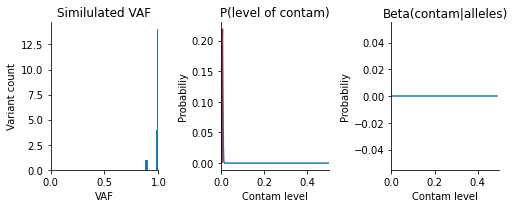

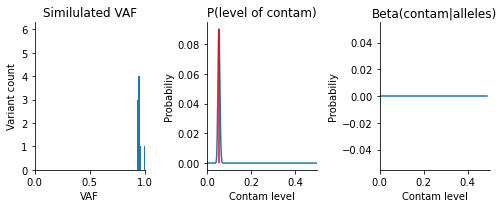

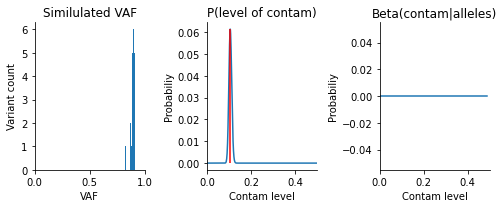

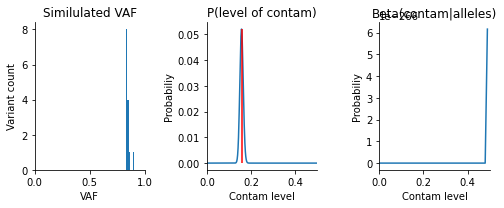

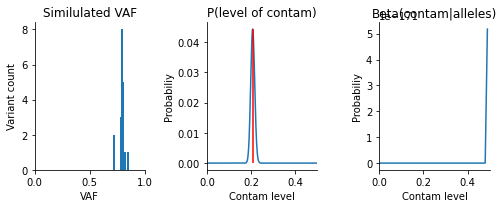

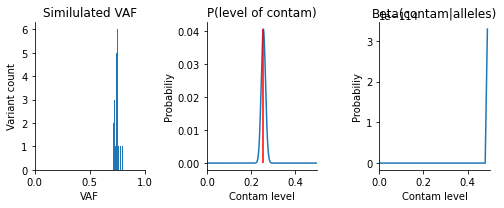

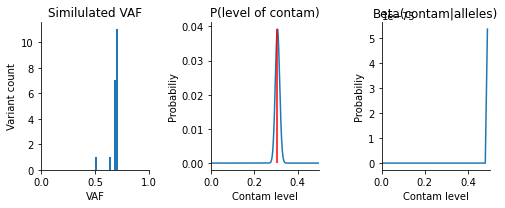

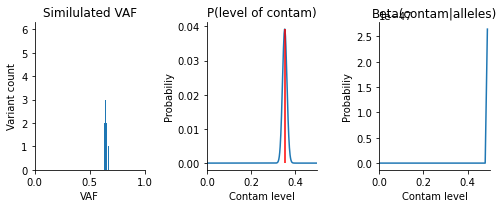

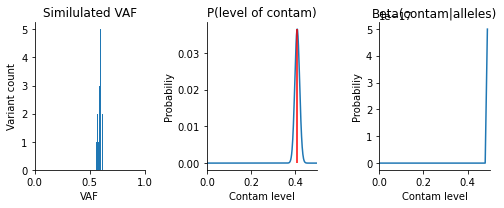

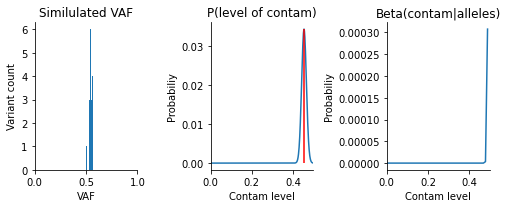

In [8]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        alt_depth = total_depth - max(0, total_depth - np.random.normal(loc=total_depth * (1-simulated_contam) ))
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HOM')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    plot_result(vp, dist, sorted_likelihoods)
    

Simulating: 0.0; Estimated: 0.499
Simulating: 0.05; Estimated: 0.056
Simulating: 0.1; Estimated: 0.11
Simulating: 0.15000000000000002; Estimated: 0.16
Simulating: 0.2; Estimated: 0.216
Simulating: 0.25; Estimated: 0.257
Simulating: 0.30000000000000004; Estimated: 0.308
Simulating: 0.35000000000000003; Estimated: 0.356
Simulating: 0.4; Estimated: 0.417
Simulating: 0.45; Estimated: 0.462


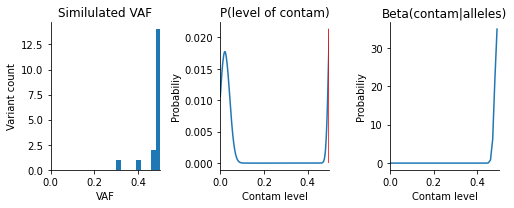

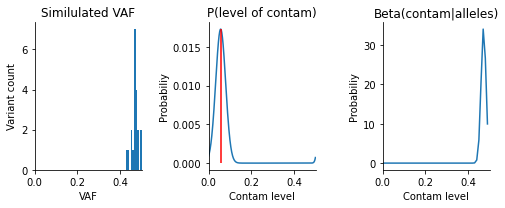

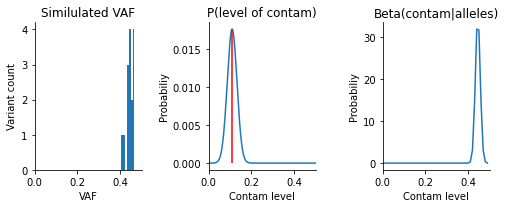

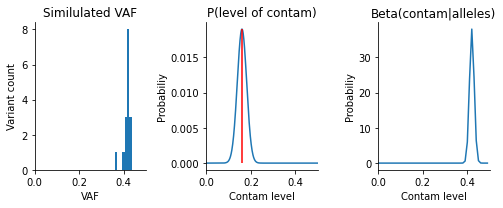

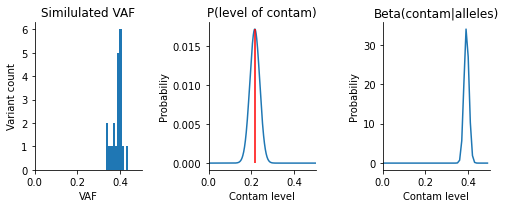

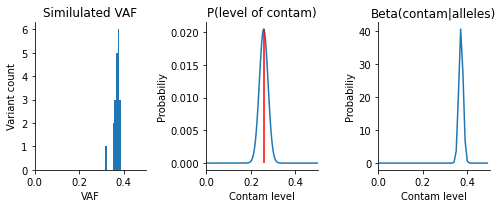

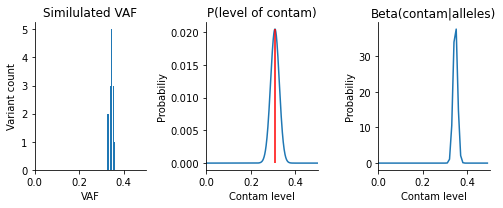

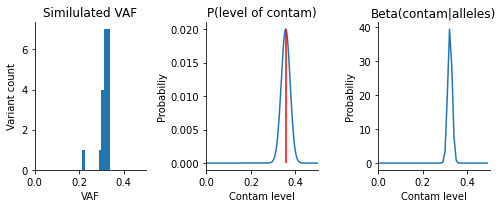

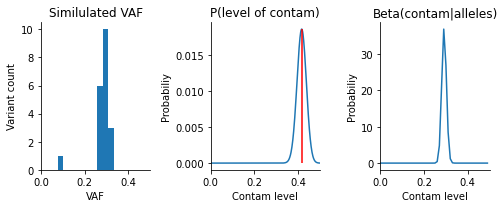

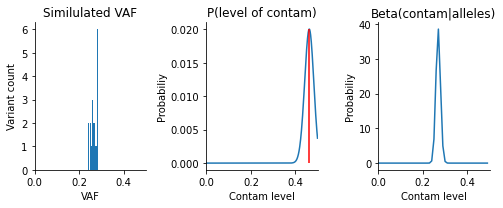

In [8]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        allele1_fraction = total_depth * 0.5
        alt_depth = total_depth / 2 
        alt_depth = np.random.normal(loc=alt_depth * (1-simulated_contam) )

        
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HET')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    
    plot_result(vp, dist, sorted_likelihoods)